# 基于SVM支持向量机的人脸识别

我们将展示如何使用支持向量机实现人脸的分类识别，主要流程是对输入的人脸数据，使用主成分分析（PCA）方法进行降维处理，然后利用降维后的数据作为人脸特征，输入到SVM中，进行人脸的分类识别

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

# 获取数据集

In [2]:
# 获取人脸数据 
faces = fetch_lfw_people(min_faces_per_person=60)

In [3]:
# 打印目标名称
print(faces.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


In [4]:
# 样本集的形状
print(faces.images.shape)

(1348, 62, 47)


In [5]:
# 获取样本个数和图像的宽高
n_samples, h, w = faces.images.shape

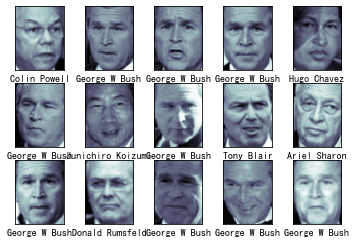

In [6]:
# 绘制样本数据，选择前15个样本进行绘制 
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

# 数据集划分

In [7]:
# 将数据集划分为训练集和测试集
xtrain, xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=2)

In [8]:
# 训练集大小
print(xtrain.shape)

(1011, 2914)


In [9]:
# 测试集大小
xtest.shape

(337, 2914)

# PCA特征提取

对人脸数据进行PCA处理，保留100维特征

In [10]:
# 对人脸数据进行PCA处理，保留100维特征
n_components =100

In [11]:
# 对PCA进行训练
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True, random_state=42).fit(xtrain)

In [12]:
# 对样本数据进行降维处理
xtrain_pca = pca.transform(xtrain)
xtest_pca = pca.transform(xtest)

In [14]:
xtest_pca.shape

(337, 100)

In [15]:
xtest.shape

(337, 2914)

# 使用线性SVM进行预测

In [16]:
# 实例化SVM
svc = SVC(kernel='linear',C=10)

In [18]:
# 训练线性SVM
svc.fit(xtrain_pca, ytrain)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [19]:
# 预测
yfit = svc.predict(xtest_pca)

In [20]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.67      0.65        21
     Colin Powell       0.74      0.75      0.75        65
  Donald Rumsfeld       0.57      0.50      0.53        24
    George W Bush       0.81      0.82      0.82       134
Gerhard Schroeder       0.83      0.58      0.68        26
      Hugo Chavez       0.94      0.88      0.91        17
Junichiro Koizumi       0.73      0.92      0.81        12
       Tony Blair       0.66      0.76      0.71        38

         accuracy                           0.76       337
        macro avg       0.74      0.74      0.73       337
     weighted avg       0.76      0.76      0.76       337



# 交叉验证

通过交叉验证的方法寻找最佳的kernel及相关参数，进行超参数调参

In [21]:
# 参数列表
param_grid = [
    {'kernel': ['linear'], 'C': [1, 5, 10, 50]},
    {'kernel': ['rbf'], 'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
    {'kernel': ['poly'], 'C': [1, 5, 10, 50], 'degree':[2,3,4], 'gamma': ['auto']}
]

In [22]:
# 3折交叉验证
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid,cv=3)

In [24]:
# 训练
%time grid.fit(xtrain_pca, ytrain)

CPU times: user 14.1 s, sys: 12.9 ms, total: 14.1 s
Wall time: 14.1 s


/Users/yaoxiaoying/.py3virtualEnv/ai/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 5, 10, 50], 'kernel': ['linear']},
                         {'C': [1, 5, 10, 50],
                          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                          'kernel': ['rbf']},
                         {'C': [1, 5, 10, 50], 'degree': [2, 3, 4],
                          'gamma': ['auto'], 'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
# 最好的模型
grid.best_estimator_

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# 使用最好的超参预测

In [26]:
# 最好的模型
model = grid.best_estimator_

In [27]:
# 预测
yfit = model.predict(xtest_pca)

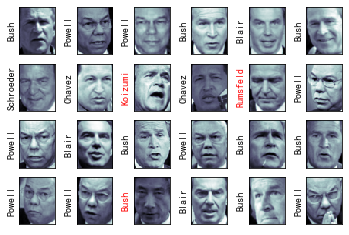

In [28]:
# 结果展示
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')

# 性能报告

In [30]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.76      0.76      0.76        21
     Colin Powell       0.88      0.91      0.89        65
  Donald Rumsfeld       0.55      0.50      0.52        24
    George W Bush       0.91      0.90      0.91       134
Gerhard Schroeder       0.72      0.81      0.76        26
      Hugo Chavez       0.93      0.82      0.87        17
Junichiro Koizumi       0.92      0.92      0.92        12
       Tony Blair       0.84      0.84      0.84        38

         accuracy                           0.85       337
        macro avg       0.81      0.81      0.81       337
     weighted avg       0.85      0.85      0.85       337



# 混淆矩阵

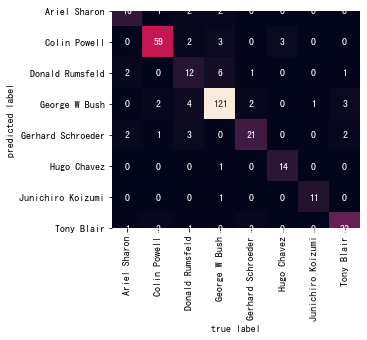

In [31]:
# 利用预测结果和真实结果绘制混淆矩阵
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');